<h1 style= "color:#9370DB;"> Stock Analysis </h1>

In [1]:
# 📚 Libraries 
import kagglehub
import pandas as pd
import numpy as np
import os

# New liabraries. 
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 📊 Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as g

# 🤖 Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 

### The Stock Analysis Dataset:


**First impressions:**
    
_____________

The **S&P 500** is a stock market index tracking the performance of the largest 500 publicly traded companies listed on U.S. stock exchanges.

Investors have long used the S&P 500 as a benchmark for their investments as it tends to signal overall market health. 
The index is a popular choice for long-term inverstors who wish to watch growth over the coming deacades. 

The dataset contains: 
- S&P 500 **Index**: Contains the daily price of the index, representing the overall performance of the 500 companies in the S&P 500.
- S&P 500 **Stocks**: Includes the daily stock prices for each company within the index, providing insights into individual stock movements. 
- S&P 500 **Companies**: Provides detailed information about each company, including metrics such as Name, Sector, Marketcap, Ebitda, Weight.

The data types are even: (13 int or float / 13 objects).

Our **project goal** is to identify the performance of various sectors in the S&P 500. After reading the [documentation](https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks) we will proceed with the following **strategy**:

1. The **target** of our dataset will be `currentprice`, which is the actual price of the stock right now.
2. Through **Exploratory Data Analysis** we will identify the features that contribute to this prediction.


_____________

<h2 style="color: #9370DB;"> 01 | Data Extraction </h2>

In [2]:
data = pd.read_csv('sp500_stocks.csv')
df = pd.read_csv('sp500_companies.csv')
sp = pd.read_csv('sp500_index.csv')

In [3]:
# Cleaning columns with snake_case 
data.columns = [col.lower().replace(" ", "_")for col in data.columns] 
df.columns = [col.lower().replace(" ", "_")for col in df.columns] 
sp.columns = [col.lower().replace(" ", "_")for col in sp.columns] 

<h3 style="color: #4169E1;">1.1 | Exploring the Data </h3>

In [4]:
data.sample(3)

,date,symbol,adj_close,close,high,low,open,volume
1602335,2015-09-03,STLD,15.705721,19.230000,20.1500,19.059999,19.530001,3121400.0
549451,2013-02-13,DXCM,3.617500,3.617500,3.6750,3.527500,3.642500,1155600.0
466486,2011-12-16,COO,17.024820,17.092501,17.2775,16.722500,16.907499,4126000.0


### Dataset Description: 

A brief analysis of each column. 
- `Date`: The specific date for which the stock date is recorded. 
- `Symbol`: A unique "ticker" code that identifies the company on the stock exchange. 
- `Adj_close`: The closing price of the stock after adjustments for dividends, splits, or other corporate actions. 
- `Close`: The unadjusted closing price of the stock on a given date.  
- `High`: The highest price at which the stock traded during the day.  
- `Low`: The lowest price at which the stock traded during the day. 
- `Open`: The price at which the stock started trading at the beginning of the day.
- `Volume`: The total number of shares traded during the day.

In [5]:
df.sample(3)

,exchange,symbol,shortname,longname,sector,industry,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,longbusinesssummary,weight
418,NYQ,MOH,Molina Healthcare Inc,"Molina Healthcare, Inc.",Healthcare,Healthcare Plans,294.99,16873426944,1.814000e+09,0.174,Long Beach,CA,United States,18000.0,"Molina Healthcare, Inc. provides managed healt...",0.000297
352,NYQ,WY,Weyerhaeuser Company,Weyerhaeuser Company,Real Estate,REIT - Specialty,31.29,22734751744,1.234000e+09,-0.169,Seattle,WA,United States,9300.0,"Weyerhaeuser Company, one of the world's large...",0.000400
148,NYQ,APD,"Air Products and Chemicals, Inc","Air Products and Chemicals, Inc.",Basic Materials,Specialty Chemicals,320.11,71185743872,4.296600e+09,-0.001,Allentown,PA,United States,23000.0,"Air Products and Chemicals, Inc. provides atmo...",0.001253


### Dataset Description: 

A brief analysis of each column: 
- `Exchange`: A marketplace where stocks, bonds or other comodities are traded. (Example: NYSE, NASDAQ).
- `Symbol`: A unique "ticker" code that identifies the company on the stock exchange. 
- `Shortname`: The abbreviated name of the company. 
- `Longname`: The full name of the company. 
- `Sector`: The broader industry classification that the company belongs to, such as Technology, Healthcare, etc. 
- `Industry`: A more specific classification of the company's operations (e.g., Software, Pharmaceuticals).
- `Currentprice`: The most recent price at which the company's stock was sold or bought. 
- `Marketprice`: The total market value of the company's outstanding shares, calculated as: Current Price X Outstanding Shares. 
- `Ebitda`: (Earnings Before Interest Taxes Depreciation and Amortization ) Measures how profitable a company is before paying interest, taxes, and taking depreciation and amortization. 
- `Revenuegrowth`: The percentage increase or decrease in sales between periods, calculated as: 
- `City`: The city where the company's headquarters is located. 
- `State`: The state where the company's headquarters is located.
- `Country`: The country of the company's origin. 
- `Fulltimeemployees`: The total number of employes of the company's business activities. 
- `Longbusinesssummary`: A breif description and overview of the company's business activities. 
- `Weight`: Represents the weight of the company's market cap relative to the total market cap, used in index calculations in the S&P 500. 


In [6]:
sp.sample(3)

,date,s&p500
513,2016-12-20,2270.76
1943,2022-08-26,4057.66
2480,2024-10-16,5842.47


### Dataset Description: 

A brief analysis of each colunn: 

- `Date`: The specific date for which the S&P 500 date is recorded. 
- `s&p500`: The closing price of the S&P 500 on a given date.  

<h3 style="color: #4169E1;">1.2 | Copies</h3>

In [7]:
data2 = data.copy()
df2 = df.copy()
sp2 = sp.copy()

<h2 style="color: #9370DB;"> 02 | ⚒️ Data Cleaning </h2>

<h3 style="color: #4169E1;"> 2.1 | Dealing with Data types</h3>

In [8]:
data.dtypes

date          object
symbol        object
adj_close    float64
close        float64
high         float64
low          float64
open         float64
volume       float64
dtype: object

In [9]:
df.dtypes

exchange                object
symbol                  object
shortname               object
longname                object
sector                  object
industry                object
currentprice           float64
marketcap                int64
ebitda                 float64
revenuegrowth          float64
city                    object
state                   object
country                 object
fulltimeemployees      float64
longbusinesssummary     object
weight                 float64
dtype: object

In [10]:
sp.dtypes

date       object
s&p500    float64
dtype: object

<h3 style="color: #4169E1;"> 2.2 | Dealing with NaN values</h3>

In [11]:
df.isna().sum()

exchange                0
symbol                  0
shortname               0
longname                0
sector                  0
industry                0
currentprice            0
marketcap               0
ebitda                 29
revenuegrowth           3
city                    0
state                  20
country                 0
fulltimeemployees       9
longbusinesssummary     0
weight                  0
dtype: int64

In [12]:
sp.isna().sum()

date      0
s&p500    0
dtype: int64

In [13]:
data.isna().sum()

date              0
symbol            0
adj_close    101626
close        101626
high         101626
low          101626
open         101626
volume       101626
dtype: int64

In [14]:
# Delete NaN. TELL WHY I'M dropping 
data2.dropna(how='any', inplace=True)

In [15]:
data2.isna().sum()

date         0
symbol       0
adj_close    0
close        0
high         0
low          0
open         0
volume       0
dtype: int64

In [16]:
# Use this as a reference conunting the same dproing them that without droping them. 
data2.symbol.value_counts()

symbol
MMM     3758
MHK     3758
NTAP    3758
NDAQ    3758
MSCI    3758
        ... 
VLTO     297
SOLV     175
GEV      175
SW       108
AMTM      53
Name: count, Length: 503, dtype: int64

<h3 style="color: #4169E1;"> 2.3 | Dealing with Duplicates</h3>

In [17]:
data2.duplicated().sum()

0

In [18]:
df.duplicated().sum()

0

In [19]:
sp.duplicated().sum()

0

<h3 style="color: #4169E1;"> 2.5 | Dealing with outliers</h3>

In [20]:
#def outlier_slayer(data): 

#    for column in data.select_dtypes(include=[np.number]):
#        Q1 = data[column].quantile(0.25)
#        Q3 = data[column].quantile(0.75)
#        IQR = Q3 - Q1
#        lower_bound = Q1 - 1.5 * IQR
#        upper_bound = Q3 + 1.5 * IQR
#        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
#    return data

In [21]:
#df = outlier_slayer(df, "price")

<h3 style="color: #4169E1;"> 2.6 | Moving target to the right </h3>

<h3 style="color: #4169E1;"> 2.7 | Other Steps </h3>

In [22]:
# Delete Columns 
data2.drop(columns=['high', 'low', 'open','close'], inplace=True)

In [23]:
# Change to datetime from stocks. 
data2['date'] = pd.to_datetime(data2['date'])
# Change to datetime. SP 500. 
sp['date'] = pd.to_datetime(sp['date'])

In [24]:
data2['year'] = data2['date'].dt.year
data2['month'] = data2['date'].dt.month
data2['day'] = data2['date'].dt.day
sp['year'] = sp['date'].dt.year
sp['month'] = sp['date'].dt.month
sp['day'] = sp['date'].dt.day

In [25]:
cols = ['year', 'month', 'day', 'symbol', 'adj_close', 'volume']
data2 = data2[cols]
data2.head(3)

,year,month,day,symbol,adj_close,volume
0,2010,1,4,MMM,43.783867,3640265.0
1,2010,1,5,MMM,43.509628,3405012.0
2,2010,1,6,MMM,44.126682,6301126.0


In [26]:
# Drop rows where year is between 2010 and 2013 because SP500 for comparison we do have 2014. 
data2.drop(data2[(data2['year'] >= 2010) & (data2['year'] <= 2014)].index, inplace=True)
# Drop row for sp 500 as we do not have many. 
sp.drop(sp[sp['year'] == 2014].index, inplace=True)

In [28]:
# Change columns for SP500. 
cols = ['year', 'month', 'day', 's&p500']
sp = sp[cols]
sp.head(3)

,year,month,day,s&p500
17,2015,1,2,2058.20
18,2015,1,5,2020.58
19,2015,1,6,2002.61


In [35]:
# Chat helped. 
annual_returns = data2.groupby(['symbol', 'year']).apply(lambda group: (group['adj_close'].iloc[-1] / group['adj_close'].iloc[0]) - 1).reset_index(name='annual_return').round(4)
annual_returns_sp = sp.groupby('year').apply(lambda group: (group['s&p500'].iloc[-1] / group['s&p500'].iloc[0]) - 1).reset_index(name='annual_return').round(4)
annual_returns_sp['symbol'] = 'SP500'

/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_12969/1225865389.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_returns = data2.groupby(['symbol', 'year']).apply(lambda group: (group['adj_close'].iloc[-1] / group['adj_close'].iloc[0]) - 1).reset_index(name='annual_return').round(4)
/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_12969/1225865389.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to 

In [36]:
cols = ['symbol', 'year', 'annual_return']
annual_returns_sp = annual_returns_sp[cols]

In [37]:
pivoted_df = annual_returns.pivot(index='symbol', columns='year', values='annual_return')
pivoted_sp = annual_returns_sp.pivot(index='symbol',columns='year', values='annual_return')

In [38]:
pivoted_df.sample(3)

year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
symbol,,,,,,,,,,
RTX,-0.1448,0.1775,0.1783,-0.1505,0.4140,-0.2368,0.2881,0.1876,-0.1434,0.4170
BG,-0.2375,0.1107,-0.0606,-0.1908,0.1179,0.1890,0.4558,0.0887,0.0835,-0.1484
ANSS,0.1330,0.0265,0.5810,-0.0378,0.7999,0.4014,0.1215,-0.3891,0.5206,-0.0218


In [39]:
pivoted_sp

year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
symbol,,,,,,,,,,
SP500,-0.0069,0.1124,0.1842,-0.0701,0.2871,0.1529,0.2879,-0.1995,0.2473,0.2809


In [40]:
defi = pd.concat([pivoted_df,pivoted_sp], axis=0) 
defi

year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
symbol,,,,,,,,,,
A,0.0418,0.1319,0.4535,0.0072,0.3098,0.3875,0.3512,-0.0374,-0.0666,0.0183
AAPL,-0.0208,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145
ABBV,-0.0714,0.1290,0.6061,-0.0267,0.0483,0.2628,0.3461,0.2399,-0.0071,0.1427
ABNB,NaN,NaN,NaN,NaN,NaN,0.0144,0.1965,-0.5049,0.6035,0.0181
ABT,0.0214,-0.0828,0.4954,0.2529,0.2705,0.2791,0.3098,-0.1971,0.0246,0.0733
...,...,...,...,...,...,...,...,...,...,...
YUM,0.0321,0.2488,0.3134,0.1462,0.1200,0.0830,0.3342,-0.0439,0.0485,0.0879
ZBH,-0.0810,0.0227,0.1774,-0.1565,0.4745,0.0413,-0.1650,0.0170,-0.0438,-0.1101
ZBRA,-0.1005,0.2898,0.2035,0.5353,0.6349,0.4831,0.5741,-0.5609,0.0505,0.5274


In [41]:
definitive = pd.merge (df2, pivoted_df, on='symbol')
definitive

,exchange,symbol,shortname,longname,sector,industry,currentprice,marketcap,ebitda,revenuegrowth,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,242.84,3670720643072,1.346610e+11,0.061,...,-0.0208,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,142.44,3488355713024,6.118400e+10,1.224,...,0.6645,2.3292,0.9043,-0.3285,0.7341,1.1802,1.2448,-0.5144,2.4610,1.9580
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,443.57,3297889746944,1.365520e+11,0.160,...,0.2188,0.1651,0.3974,0.2022,0.5826,0.3994,0.5579,-0.2769,0.5835,0.2050
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,227.03,2387220627456,1.115830e+11,0.110,...,1.1907,0.1772,0.5517,0.2632,0.2006,0.7160,0.0464,-0.5071,0.7704,0.5142
4,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,176.49,2149065949184,1.234700e+11,0.151,...,0.4500,0.0404,0.3311,-0.0276,0.2784,0.2812,0.6743,-0.3884,0.5711,0.2646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,NYQ,BWA,BorgWarner Inc.,BorgWarner Inc.,Consumer Cyclical,Auto Parts,33.80,7392059904,1.882000e+09,-0.048,...,-0.2022,-0.0517,0.2918,-0.3189,0.2572,-0.1037,0.2019,-0.0940,0.0245,-0.0471
499,NYQ,HII,"Huntington Ingalls Industries,","Huntington Ingalls Industries, Inc.",Industrials,Aerospace & Defense,187.95,7354351616,1.071000e+09,-0.024,...,0.1491,0.5029,0.2615,-0.1545,0.3244,-0.3181,0.1651,0.2680,0.1633,-0.2620
500,NYQ,FMC,FMC Corporation,FMC Corporation,Basic Materials,Agricultural Inputs,56.58,7063221248,7.033000e+08,0.085,...,-0.3028,0.5106,0.6741,-0.2186,0.5627,0.1725,-0.0103,0.1542,-0.4807,-0.1023
501,NMS,QRVO,"Qorvo, Inc.","Qorvo, Inc.",Technology,Semiconductors,68.33,6459010048,6.731300e+08,-0.052,...,-0.2770,0.0396,0.2590,-0.1183,0.8998,0.4339,-0.0498,-0.4315,0.2633,-0.3726


In [42]:
definitive = definitive.rename(columns={2015: 'ar_2015',2016:'ar_2016',2017: 'ar_2017', 
                                          2018:'ar_2018', 2019: 'ar_2019',2020: 'ar_2020', 2021: 'ar_2021', 2022:'ar_2022', 2023:'ar_2023',2024: 'ar_2024'})

In [43]:
#Dropping Columns: Exchange, longname, longbusinesssumary. 
cols = ['symbol', 'shortname','sector','industry',
        'marketcap','ebitda', 'revenuegrowth', 'city', 'state', 'country',   
        'fulltimeemployees', 'weight', 'ar_2015', 'ar_2016', 'ar_2017', 'ar_2018', 'ar_2019',
        'ar_2020', 'ar_2021', 'ar_2022', 'ar_2023', 'ar_2024', 'currentprice']

In [44]:
definitive = definitive[cols]

In [45]:
definitive

,symbol,shortname,sector,industry,marketcap,ebitda,revenuegrowth,city,state,country,...,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024,currentprice
0,AAPL,Apple Inc.,Technology,Consumer Electronics,3670720643072,1.346610e+11,0.061,Cupertino,CA,United States,...,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145,242.84
1,NVDA,NVIDIA Corporation,Technology,Semiconductors,3488355713024,6.118400e+10,1.224,Santa Clara,CA,United States,...,2.3292,0.9043,-0.3285,0.7341,1.1802,1.2448,-0.5144,2.4610,1.9580,142.44
2,MSFT,Microsoft Corporation,Technology,Software - Infrastructure,3297889746944,1.365520e+11,0.160,Redmond,WA,United States,...,0.1651,0.3974,0.2022,0.5826,0.3994,0.5579,-0.2769,0.5835,0.2050,443.57
3,AMZN,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,2387220627456,1.115830e+11,0.110,Seattle,WA,United States,...,0.1772,0.5517,0.2632,0.2006,0.7160,0.0464,-0.5071,0.7704,0.5142,227.03
4,GOOG,Alphabet Inc.,Communication Services,Internet Content & Information,2149065949184,1.234700e+11,0.151,Mountain View,CA,United States,...,0.0404,0.3311,-0.0276,0.2784,0.2812,0.6743,-0.3884,0.5711,0.2646,176.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,BWA,BorgWarner Inc.,Consumer Cyclical,Auto Parts,7392059904,1.882000e+09,-0.048,Auburn Hills,MI,United States,...,-0.0517,0.2918,-0.3189,0.2572,-0.1037,0.2019,-0.0940,0.0245,-0.0471,33.80
499,HII,"Huntington Ingalls Industries,",Industrials,Aerospace & Defense,7354351616,1.071000e+09,-0.024,Newport News,VA,United States,...,0.5029,0.2615,-0.1545,0.3244,-0.3181,0.1651,0.2680,0.1633,-0.2620,187.95
500,FMC,FMC Corporation,Basic Materials,Agricultural Inputs,7063221248,7.033000e+08,0.085,Philadelphia,PA,United States,...,0.5106,0.6741,-0.2186,0.5627,0.1725,-0.0103,0.1542,-0.4807,-0.1023,56.58
501,QRVO,"Qorvo, Inc.",Technology,Semiconductors,6459010048,6.731300e+08,-0.052,Greensboro,NC,United States,...,0.0396,0.2590,-0.1183,0.8998,0.4339,-0.0498,-0.4315,0.2633,-0.3726,68.33


<h2 style="color: #9370DB;"> 03 | EDA (Exploratory Data Analysis) </h2>

<h3 style="color: #4169E1;"> Optional | Selecting Numerical </h3>

In [46]:
cat = definitive.select_dtypes(exclude='number')
cat.head(5)

,symbol,shortname,sector,industry,city,state,country
0,AAPL,Apple Inc.,Technology,Consumer Electronics,Cupertino,CA,United States
1,NVDA,NVIDIA Corporation,Technology,Semiconductors,Santa Clara,CA,United States
2,MSFT,Microsoft Corporation,Technology,Software - Infrastructure,Redmond,WA,United States
3,AMZN,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,Seattle,WA,United States
4,GOOG,Alphabet Inc.,Communication Services,Internet Content & Information,Mountain View,CA,United States


In [47]:
num = definitive.select_dtypes(include='number')
num.head(5)

,marketcap,ebitda,revenuegrowth,fulltimeemployees,weight,ar_2015,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024,currentprice
0,3670720643072,1.346610e+11,0.061,164000.0,0.064589,-0.0208,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145,242.84
1,3488355713024,6.118400e+10,1.224,29600.0,0.061381,0.6645,2.3292,0.9043,-0.3285,0.7341,1.1802,1.2448,-0.5144,2.4610,1.9580,142.44
2,3297889746944,1.365520e+11,0.160,228000.0,0.058029,0.2188,0.1651,0.3974,0.2022,0.5826,0.3994,0.5579,-0.2769,0.5835,0.2050,443.57
3,2387220627456,1.115830e+11,0.110,1551000.0,0.042005,1.1907,0.1772,0.5517,0.2632,0.2006,0.7160,0.0464,-0.5071,0.7704,0.5142,227.03
4,2149065949184,1.234700e+11,0.151,181269.0,0.037815,0.4500,0.0404,0.3311,-0.0276,0.2784,0.2812,0.6743,-0.3884,0.5711,0.2646,176.49


<h3 style="color: #4169E1;">3.1 | Descriptive Statistics </h3>

In [48]:
definitive.describe()

,marketcap,ebitda,revenuegrowth,fulltimeemployees,weight,ar_2015,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024,currentprice
count,5.030000e+02,4.740000e+02,500.000000,4.940000e+02,503.000000,475.000000,480.000000,482.000000,485.000000,491.000000,495.000000,495.000000,497.000000,499.000000,503.000000,503.000000
mean,1.129853e+11,7.031397e+09,0.070484,5.774496e+04,0.001988,0.045306,0.197734,0.258852,-0.034976,0.352786,0.192008,0.328778,-0.085353,0.195019,0.215239,230.293300
std,3.399129e+11,1.622777e+10,0.180071,1.394693e+05,0.005981,0.253423,0.277769,0.260448,0.225112,0.317066,0.548745,0.295113,0.279833,0.356690,0.382605,521.997583
min,5.637307e+09,-3.991000e+09,-0.602000,2.800000e+01,0.000099,-0.753000,-0.710600,-0.430800,-0.576200,-0.543300,-0.580300,-0.350500,-0.710700,-0.480700,-0.652500,8.560000
25%,2.036663e+10,1.623194e+09,0.002000,1.020000e+04,0.000358,-0.107050,0.047800,0.094325,-0.192900,0.185550,-0.051000,0.131250,-0.266900,-0.028700,0.004500,71.545000
50%,3.803281e+10,2.941705e+09,0.050000,2.159500e+04,0.000669,0.040700,0.177950,0.223250,-0.037800,0.328700,0.123900,0.306900,-0.114600,0.127500,0.167400,126.820000
75%,8.419720e+10,6.017250e+09,0.109000,5.476225e+04,0.001482,0.177300,0.310375,0.386175,0.093100,0.478200,0.302250,0.472350,0.057700,0.324050,0.371450,239.190000
max,3.670721e+12,1.495470e+11,1.632000,2.100000e+06,0.064589,1.722800,3.093900,1.427200,1.065900,4.311000,7.200500,1.900200,1.071300,2.461000,3.604300,8946.330000


In [49]:
frequency_table = cat.sector.value_counts()
proportion_table = cat.sector.value_counts(normalize=True)

In [50]:
frequency_proportion = pd.concat([frequency_table,proportion_table], axis = 1)
frequency_proportion.columns = ['absolute_frequency', 'relative_frequency']

In [51]:
total_absolute = frequency_table.sum()
total_relative = proportion_table.sum()


In [52]:
total_row = pd.DataFrame({
    'absolute_frequency': [total_absolute],
    'relative_frequency': [total_relative]
}, index=['Total'])

In [53]:
df3 = pd.concat([frequency_proportion, total_row])
df3

,absolute_frequency,relative_frequency
Technology,82,0.163022
Industrials,70,0.139165
Financial Services,67,0.133201
Healthcare,63,0.125249
Consumer Cyclical,55,0.109344
Consumer Defensive,37,0.073559
Utilities,32,0.063618
Real Estate,31,0.061630
Communication Services,22,0.043738
Energy,22,0.043738


/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_12969/3055570902.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


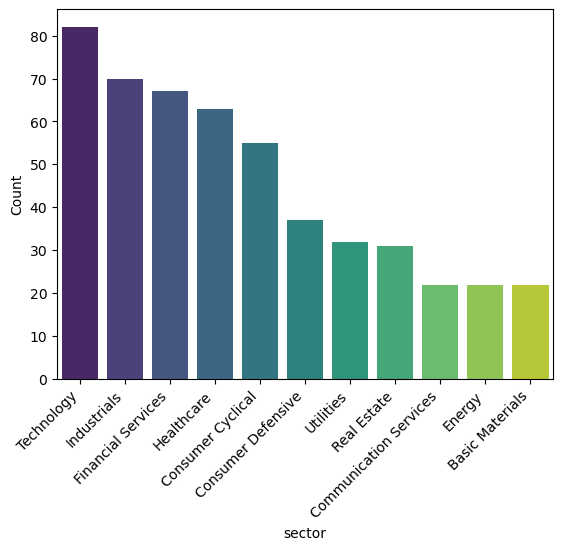

In [54]:
sns.barplot(
    x='sector',
    y='absolute_frequency',
    data=frequency_proportion,
    palette='viridis',
)
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

The frequency table gives the count of each sector, while the proportion table provides the percentage representation of each category in the dataset. This helps to quickly identify dominant and minority categories. Such as:
- Technology: 16% 
- Industrials: 14% 
- Financial Services: 13% 
- Healthcare: 12% 
- Consumer Cyclical: 10% 

/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_12969/4204257818.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x="shortname", y="sector", data=sector_breakdown, palette=('coolwarm'))
/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_12969/4204257818.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x="marketcap", y="sector", data=sector_breakdown, palette=('Wistia'))
/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_12969/4204257818.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(

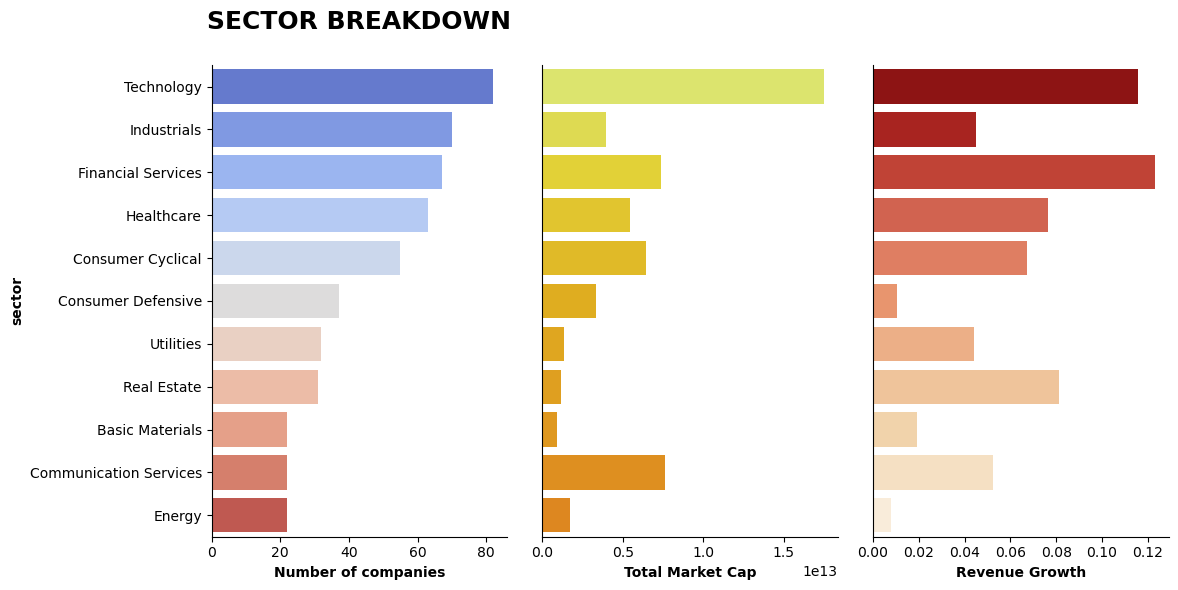

In [55]:
# Found out in Kaggle related notebooks. 
f = {'revenuegrowth':['mean'], 'marketcap':['sum'], 'shortname':['count']}

sector_breakdown = definitive.groupby('sector').agg(f)
sector_breakdown.columns = sector_breakdown.columns.get_level_values(0)
sector_breakdown = sector_breakdown.reset_index()
sector_breakdown = sector_breakdown.sort_values('shortname', ascending=False)

fig = plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')

plt.subplot(1, 3, 1)
ax1 = sns.barplot(x="shortname", y="sector", data=sector_breakdown, palette=('coolwarm'))
ax1.set_xlabel('Number of companies', weight='bold')
ax1.set_ylabel('sector', weight = 'bold')
ax1.set_title('SECTOR BREAKDOWN\n', weight='bold').set_fontsize('18')

plt.subplot(1, 3, 2)
ax2 = sns.barplot(x="marketcap", y="sector", data=sector_breakdown, palette=('Wistia'))
ax2.set_xlabel('Total Market Cap', weight='bold')
ax2.set_ylabel('')
ax2.set_yticks([])

plt.subplot(1, 3, 3)
ax2 = sns.barplot(x="revenuegrowth", y="sector", data=sector_breakdown, palette=('OrRd_r'))
ax2.set_xlabel('Revenue Growth', weight='bold')
ax2.set_ylabel('')
ax2.set_yticks([])

sns.despine()
plt.tight_layout();

In [56]:
round(definitive.groupby('sector')['revenuegrowth'].agg(['mean', 'median', 'count', 'max']), 2)

,mean,median,count,max
sector,,,,
Basic Materials,0.02,0.00,22,0.85
Communication Services,0.05,0.04,21,0.19
Consumer Cyclical,0.07,0.04,55,1.63
Consumer Defensive,0.01,-0.00,37,0.27
Energy,0.01,-0.01,22,0.20
Financial Services,0.12,0.12,67,1.33
Healthcare,0.08,0.06,63,0.31
Industrials,0.05,0.03,70,0.49
Real Estate,0.08,0.07,30,0.29


### Which is the leading sector in S&P 500: 

Analysis: 

- The **Technology** sector stands out in the number of companies and total market cap. 
- On the other hand, **Financial Services** sector has the stocks with the most revenue growth. 
- The **Energy** sector has the least Number of companies and Revenue Growth. 

In [57]:
tech = definitive[definitive['sector'] == 'Technology']
indus = definitive[definitive['sector'] == 'Industrials']
fin = definitive[definitive['sector'] == 'Financial Services']
health = definitive[definitive['sector'] == 'Healthcare']
consumer = definitive[definitive['sector'] == 'Consumer Cyclical']

In [58]:
annual_returns = definitive.groupby('sector')[['ar_2015', 'ar_2016', 'ar_2017','ar_2018', 'ar_2019', 'ar_2020','ar_2021','ar_2022','ar_2023','ar_2024' ]].agg(['mean']).round(4)
annual_returns

,ar_2015,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
sector,,,,,,,,,,
Basic Materials,-0.0515,0.3317,0.2620,-0.1485,0.2362,0.2180,0.3918,-0.0591,0.0989,0.0123
Communication Services,0.1711,0.1851,0.2660,-0.0479,0.2880,0.2042,0.1508,-0.2962,0.2704,0.2761
Consumer Cyclical,0.1161,0.1185,0.3184,-0.0525,0.3259,0.2717,0.3050,-0.1924,0.3123,0.2229
Consumer Defensive,0.1367,0.0827,0.1464,-0.0459,0.2970,0.1340,0.1715,0.0250,-0.0458,0.0367
Energy,-0.2032,0.4439,0.0230,-0.1985,0.1119,-0.2809,0.6197,0.5490,0.0717,0.1900
Financial Services,0.0260,0.2298,0.2444,-0.0898,0.3654,0.0585,0.3616,-0.0795,0.1322,0.3329
Healthcare,0.1084,0.0638,0.2840,0.0600,0.3132,0.2895,0.2844,-0.0590,0.0447,0.0128
Industrials,-0.0132,0.2783,0.2927,-0.1018,0.3946,0.2213,0.3149,-0.0760,0.2692,0.2754


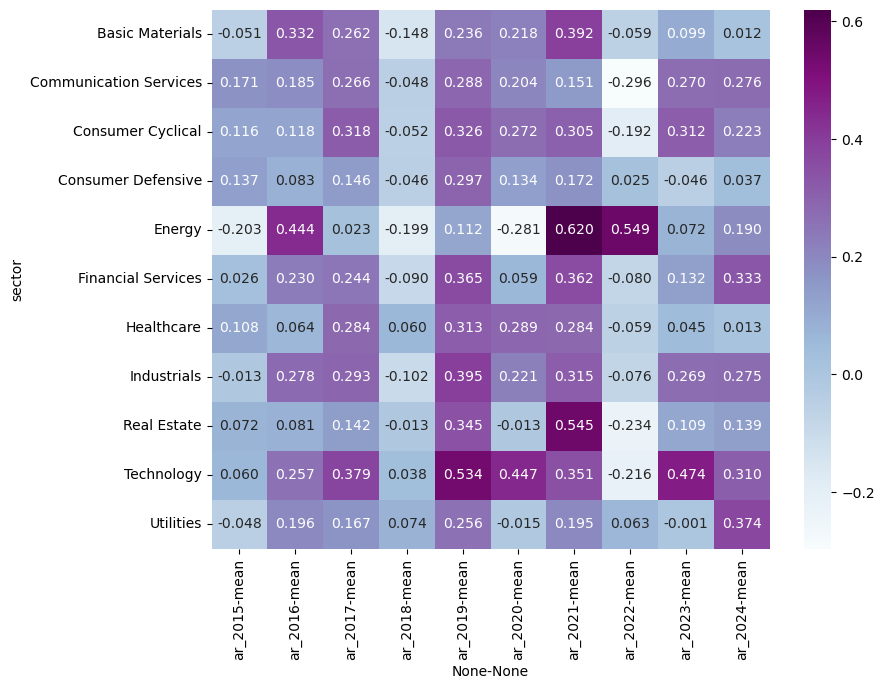

In [59]:
plt.figure(figsize=(9, 7)) 
sns.heatmap(annual_returns, annot=True, cmap="BuPu", fmt=".3f")
plt.show()

### Annual Return sector in S&P 500: 

Calculated the annual return for each sector from 2015 to 2014, analyzing the performance trends across different industries over time.
Observations: 

- The **Energy** sector stands out in 2021 being the highest anual return. 
- On the other hand, **Technology** sector has the most recurrent annual return. 

In [78]:
sorted_df = defi.sort_values(by=2024, ascending=False)
sorted_df = sorted_df.reset_index()
sorted_df.columns.name = None

In [79]:
sorted_df

,symbol,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,PLTR,NaN,NaN,NaN,NaN,NaN,1.4789,-0.2208,-0.6535,1.6870,3.6043
1,VST,NaN,0.1662,0.1927,0.2427,0.0480,-0.1129,0.2257,0.0521,0.7787,3.2378
2,NVDA,0.6645,2.3292,0.9043,-0.3285,0.7341,1.1802,1.2448,-0.5144,2.4610,1.9580
3,AXON,-0.3478,0.4403,0.0781,0.6478,0.6245,0.6004,0.3436,0.0854,0.5355,1.7329
4,TPL,0.1117,1.3837,0.4975,0.1851,0.3910,-0.0243,0.6648,0.8750,-0.2463,1.5535
...,...,...,...,...,...,...,...,...,...,...,...
499,DLTR,0.0977,-0.0207,0.3855,-0.1690,0.0313,0.1521,0.3140,0.0019,0.0128,-0.4958
500,CE,0.1425,0.2159,0.3718,-0.1405,0.3795,0.0976,0.3594,-0.3868,0.5192,-0.5441
501,INTC,-0.0240,0.1023,0.2969,0.0269,0.3030,-0.1608,0.0637,-0.4836,0.9238,-0.5565
502,MRNA,NaN,NaN,NaN,-0.1790,0.2759,4.4327,1.2732,-0.2358,-0.4444,-0.6050


In [70]:
sorted_df[sorted_df['symbol'] == 'SP500']

year,symbol,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
171,SP500,-0.0069,0.1124,0.1842,-0.0701,0.2871,0.1529,0.2879,-0.1995,0.2473,0.2809


In [80]:
sample_symbols = ['AAPL', 'MSFT','CAT','GE', 'MA','JPM','LLY','UNH','AMZN','MCD', 'SP500']
sample_df = sorted_df[sorted_df['symbol'].isin(sample_symbols)]

In [81]:
sample_df

,symbol,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
22,GE,0.2860,0.0612,-0.4308,-0.5670,0.4476,-0.0901,0.1314,-0.1256,0.9297,0.7554
73,AMZN,1.1907,0.1772,0.5517,0.2632,0.2006,0.7160,0.0464,-0.5071,0.7704,0.5142
89,JPM,0.0783,0.3870,0.2539,-0.0750,0.4475,-0.0667,0.2896,-0.1445,0.2964,0.4718
118,LLY,0.2348,-0.0887,0.1618,0.4009,0.1699,0.3027,0.6943,0.3647,0.6128,0.4051
133,CAT,-0.2327,0.4389,0.7271,-0.1727,0.2017,0.2456,0.1587,0.1629,0.2377,0.3496
149,AAPL,-0.0208,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145
171,SP500,-0.0069,0.1124,0.1842,-0.0701,0.2871,0.1529,0.2879,-0.1995,0.2473,0.2809
186,MA,0.1445,0.0978,0.4469,0.2486,0.5824,0.1828,0.0273,-0.0614,0.2298,0.2529
226,MSFT,0.2188,0.1651,0.3974,0.2022,0.5826,0.3994,0.5579,-0.2769,0.5835,0.2050
357,UNH,0.1864,0.3981,0.3861,0.1416,0.2278,0.2186,0.4569,0.0691,0.0304,0.0311


/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_12969/3031598821.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sample_df, x='symbol', y=columns, ci=None)


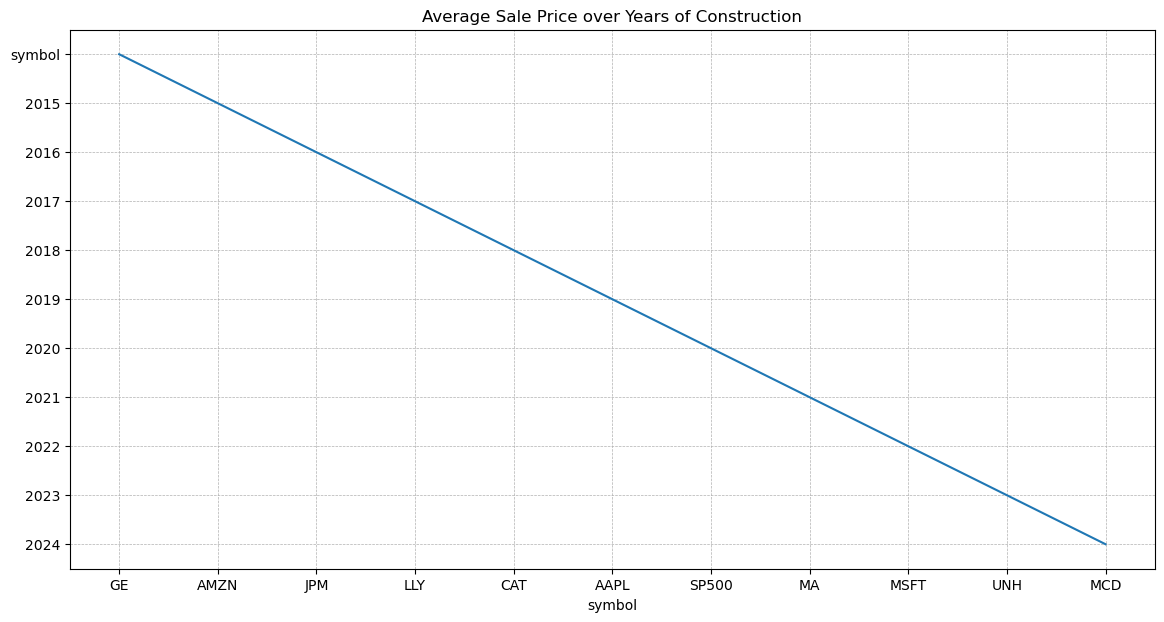

In [85]:
# Plotting a line graph to visualize the trend of average 'SalePrice' across different 'YearBuilt'
plt.figure(figsize=(14, 7))
columns = ['symbol','2015', '2016','2017','2018', '2019', '2020', '2021', '2022', '2023', '2024']
sns.lineplot(data=sample_df, x='symbol', y=columns, hue='symbol')
plt.title('Average Sale Price over Years of Construction')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### Annual Return 2024 stocks vs S&P 500: 

Calculated the annual return for each sector from 2015 to 2014, analyzing the performance trends across different industries over time.
Observations: 

- The **Energy** sector stands out in 2021 being the highest anual return. 
- On the other hand, **Technology** sector has the most recurrent annual return. 

<h3 style="color: #4169E1;"> 3.2 | Checking Distributions</h3>

In [ ]:
color = '#9370DB'

nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)  # hide unesed plots
        continue
    ax.hist(num.iloc[:, i], bins=30, color=color, edgecolor='black')
    ax.set_title(num.columns[i])

plt.tight_layout()
plt.show()

<h3 style="color: #4169E1;"> 3.3 | Checking our target distribution</h3>

In [ ]:
# Without the filter 650.000 and taking out the outliers. 
sns.histplot(definitive["currentprice"], color=color, kde=True);

In [ ]:
d2 = sns.displot(data=definitive, x='currentprice', kde=True, height=8, aspect=1.6, bins=100, binrange=(0, 2100), color='mediumpurple')
d2.set(xlabel='Current Price')
plt.xlim(0, 2100)

In [ ]:
#pearson 
num.corrwith(definitive['currentprice']).sort_values(ascending=False)

In [ ]:
#Spearman
num.corrwith(df['currentprice'], method='spearman').sort_values(ascending=False)[:5]

<h3 style="color: #4169E1;">3.4 | Checking Outliers </h3>

In [ ]:
color = '#9370DB'

# grid size
nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)
        continue
    ax.boxplot(num.iloc[:, i].dropna(), vert=False, patch_artist=True, 
               boxprops=dict(facecolor=color, color='black'), 
               medianprops=dict(color='yellow'), whiskerprops=dict(color='black'), 
               capprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=5))
    ax.set_title(num.columns[i], fontsize=10)
    ax.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

<h3 style="color: #4169E1;">3.5 | Looking for Correlations </h3>

In [ ]:
num_corr = num.corr()
num_corr

In [ ]:
# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True 
f, ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale=1.5)

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="BuPu", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation Heatmap", fontsize=20) 

In [ ]:
# Plotting scatter plots for each numerical column against 'currentprice' to visualize their relationships
for col in num.columns:
    plt.figure(figsize=(5, 5))
    plt.title('Scatter plot of price vs ' + col)
    sns.scatterplot(data=definitive, x=col, y='currentprice')
    plt.show()

We will use **one-way ANOVA** to determine if there is a statistically significant difference in **stock price** based on **sector**.

#### Define Hypotheses
- **Null Hypothesis (H₀)**: There is no difference in mean stock prices between sectors such as at **Technolgies**, **Industrials**, and **Finance** companies.
- **Alternative Hypothesis (H₁)**: At least one group mean is different.

In [ ]:
# Extract salaries for Data Scientists by company size
df_small = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Small")]["salary_in_usd"]
df_medium = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Medium")]["salary_in_usd"]
df_large = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Large")]["salary_in_usd"]

In [ ]:
# Perform One-Way ANOVA
f_stat, p_value = st.f_oneway(df_small, df_medium, df_large)
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print()

# Significance level
alpha = 0.05

# Decision-Making
if p_value > alpha:
    print("Fail to Reject the Null Hypothesis: Company size has no significant impact on data scientist salaries.")
else:
    print("Reject the Null Hypothesis: There is a significant difference in salaries based on company size.")

<h2 style="color: #9370DB;"> 04 | Data Processing </h2>

<h3 style="color: #4169E1;"> 4.1 | X-Y Split</h3>

<h3 style="color: #4169E1;"> 4.2 | Selecting the Model</h3>

<h4 style="color: #00BFFF;"> 4.2.1 | Selecting Model: Linear Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.2 | Selecting Model: Ridge Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.3 | Selecting Model: Lasso Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.4 | Selecting Model: Decision Tree Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.5 | Selecting Model: KNN Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.6 | Selecting Model: XGBoost Regression </h4>

<h3 style="color: #4169E1;"> 4.3 | Final Comparision</h3>

<h2 style="color: #9370DB;"> 05 | Improving Model </h2>

<h3 style="color: #4169E1;"> 5.1 | Normalization with MinMaxScaler</h3>

<h3 style="color: #4169E1;"> 5.2 | Standardization with StandardScaler</h3>

<h3 style="color: #4169E1;"> 5.3 | Normzalization with Long Transform</h3>

<h3 style="color: #4169E1;"> 5.4 | Feature Engineering </h3>

<h2 style="color: #9370DB;"> 06 | Reporting </h2>